In [1]:
import neural_net_without_autograd as NNC

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

from sklearn.model_selection import  train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Generating the dataset and splitting the data

In [2]:
np.random.seed(42)

# --- defining the Franke function
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

# --- Generating dataset
n = 100 # the square root of the number of datapoints
x, y = np.linspace(0,1,n), np.linspace(0,1,n)
x, y = np.meshgrid(x, y)
x = x.ravel()
y = y.ravel()

k = .01 # noise coefficient
z = FrankeFunction(x,y) + k*np.random.randn(n**2) # target variable with standard normal noise
z = z.reshape((len(z), 1))      # have to reshape the data to get the correct output

X = np.column_stack((x,y))

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=0)

### Gridsearch

Gridsearch checking different learning rates and regularization parameters for different activation functions:

In [15]:
# Define layer sizes and activations
network_input_size =  2
layer_output_sizes = [50, 1]
activations = ['sigmoid', 'identity']

k_folds = KFold(n_splits=5)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', NNC.NeuralNet(network_input_size, layer_output_sizes, activations, loss_fn='mse', batch_size=512, epochs=500))
])
param_grid = {
    'model__epsilon': np.logspace(-4, -1, 4),
    'model__llambda': [0, 0.001, 0.1, 10],
    'model__activations': [['sigmoid', 'identity'], ['relu', 'identity'], ['elu', 'identity']]
}

grid_search = GridSearchCV(estimator=pipeline,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                cv=k_folds,
                verbose=3,
                n_jobs=1)
gs = grid_search.fit(X_train, z_train)
print(-gs.best_score_)
print(gs.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Epoch 0: MSE = 5.2070136476779325
Epoch 100: MSE = 1.2341701035325776
Epoch 200: MSE = 0.3359794605046821
[CV 1/5] END model__activations=['sigmoid', 'identity'], model__epsilon=0.0001, model__llambda=0;, score=-0.117 total time=   1.4s
Epoch 0: MSE = 21.07928999641459
Epoch 100: MSE = 1.3940735324483748
Epoch 200: MSE = 0.46975754883489784
[CV 2/5] END model__activations=['sigmoid', 'identity'], model__epsilon=0.0001, model__llambda=0;, score=-0.195 total time=   1.5s
Epoch 0: MSE = 4.627848260650702
Epoch 100: MSE = 1.1453318693912644
Epoch 200: MSE = 0.34229305658339454
[CV 3/5] END model__activations=['sigmoid', 'identity'], model__epsilon=0.0001, model__llambda=0;, score=-0.141 total time=   1.5s
Epoch 0: MSE = 9.924657128971413
Epoch 100: MSE = 1.0796468850275895
Epoch 200: MSE = 0.34184393629723003
[CV 4/5] END model__activations=['sigmoid', 'identity'], model__epsilon=0.0001, model__llambda=0;, score=-0.145 total tim

Saving the results

In [16]:
cv_results = grid_search.cv_results_

results_df = pd.DataFrame(cv_results)

# save data to csv-file
results_df.to_csv('Results/gridsearch_regression_300_epochs_diff_lambda.csv', sep=',', encoding='utf-8')

### Batch Size

Calculating the MSE as a function of the learning rate for different batch sizes and saving the results

In [12]:
# Define layer sizes and activations
network_input_size =  2
layer_output_sizes = [50, 1]
activations = ['sigmoid', 'identity']

N = 100
learning_rates = np.logspace(-4, -1, N)
batch_sizes = [32, 64, 128, 256, 512]
scores = np.zeros((len(batch_sizes), N))

for idy, batch_size in enumerate(batch_sizes):  
    for idx, lr in enumerate(learning_rates):
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', NNC.NeuralNet(network_input_size, 
                                    layer_output_sizes, 
                                    activations, 
                                    epochs=10, 
                                    epsilon=lr, 
                                    batch_size=batch_size,
                                    loss_fn='mse'))
        ])

        pipeline.fit(X_train, z_train)
        score = pipeline.score(X_test, z_test)

        scores[idy, idx] = score

Epoch 0: MSE = 2.530834159014872
Epoch 0: MSE = 1.1336648643064466
Epoch 0: MSE = 3.6838155788059375
Epoch 0: MSE = 5.230608092785308
Epoch 0: MSE = 3.4660721628067166
Epoch 0: MSE = 1.538573884859442
Epoch 0: MSE = 0.822956873946993
Epoch 0: MSE = 0.4571249359841304
Epoch 0: MSE = 0.9138312197139664
Epoch 0: MSE = 1.7188449826853607
Epoch 0: MSE = 1.2992940060839273
Epoch 0: MSE = 2.3059593411434327
Epoch 0: MSE = 0.8454838395918762
Epoch 0: MSE = 3.0513688934873704
Epoch 0: MSE = 1.8079342840092822
Epoch 0: MSE = 2.114085662083381
Epoch 0: MSE = 1.072978910926292
Epoch 0: MSE = 0.3427868776080909
Epoch 0: MSE = 0.44224474800207336
Epoch 0: MSE = 0.790875600139229
Epoch 0: MSE = 0.9825507726398112
Epoch 0: MSE = 0.7586804102820723
Epoch 0: MSE = 1.4659467645930186
Epoch 0: MSE = 0.40356235188679307
Epoch 0: MSE = 0.4009473222108124
Epoch 0: MSE = 1.937225948420582
Epoch 0: MSE = 0.3018195468255407
Epoch 0: MSE = 0.3729890466021517
Epoch 0: MSE = 1.0351018221893165
Epoch 0: MSE = 0.250

In [14]:
np.save('Results/regression_own_code_scores_batch_size.npy', scores)
np.save('Results/learning_rates_regression.npy', learning_rates)

### Learning rate

Calculating the MSE as a function of the learning rate

In [3]:
N = 200
learning_rates = np.logspace(-4, -1, N)
scores = np.zeros(N)
network_input_size = 2
layer_output_sizes = [50, 1]
activations = ['sigmoid', 'identity']

for idx, lr in enumerate(learning_rates):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', NNC.NeuralNet(network_input_size, layer_output_sizes, activations, epochs=10, epsilon=lr, batch_size=32, loss_fn='mse'))
    ])

    pipeline.fit(X_train, z_train)
    score = pipeline.score(X_test, z_test)

    scores[idx] = score

Epoch 0: MSE = 3.5157377451278453
Epoch 0: MSE = 0.9832916481607954
Epoch 0: MSE = 14.59756142383542
Epoch 0: MSE = 7.886891284248197
Epoch 0: MSE = 4.77452324518501
Epoch 0: MSE = 3.9887066241094224
Epoch 0: MSE = 3.743396122743681
Epoch 0: MSE = 1.4472664847716046
Epoch 0: MSE = 3.973501246599085
Epoch 0: MSE = 1.3247323542941671
Epoch 0: MSE = 8.629615699149577
Epoch 0: MSE = 0.23871303872415184
Epoch 0: MSE = 3.5965162290158252
Epoch 0: MSE = 3.7475920481486504
Epoch 0: MSE = 8.13372306882783
Epoch 0: MSE = 3.986434036326239
Epoch 0: MSE = 0.24800178846810075
Epoch 0: MSE = 3.7209516847054527
Epoch 0: MSE = 2.9057896093862348
Epoch 0: MSE = 2.055785848213889
Epoch 0: MSE = 5.396794375212492
Epoch 0: MSE = 5.008817263560596
Epoch 0: MSE = 3.5862467023681295
Epoch 0: MSE = 1.5303562871938579
Epoch 0: MSE = 0.2315420402885142
Epoch 0: MSE = 0.9380608550020837
Epoch 0: MSE = 0.6874648189741585
Epoch 0: MSE = 1.4520869617864733
Epoch 0: MSE = 1.37474851041887
Epoch 0: MSE = 1.0508949439

In [4]:
np.save('Results/regression_own_code_learning_rate.npy', scores)
np.save('Results/learning_rates_regression_comparison.npy', learning_rates)

### Plotting the prediction and the data

Calculating the MSE test score for the model parameters found using gridsearch and using this model to fit the entire dataset to plot the predicted model.

In [3]:
# Define layer sizes and activations
network_input_size =  2
layer_output_sizes = [50, 1]
activations = ['sigmoid', 'identity']

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', NNC.NeuralNet(network_input_size, layer_output_sizes, activations, loss_fn='mse', batch_size=32, epochs=500, epsilon=0.1))
])

pipeline.fit(X_train, z_train)
pipeline.score(X_test, z_test)

Epoch 0: MSE = 0.0222039562354707
Epoch 100: MSE = 0.0012181035868071022
Epoch 200: MSE = 0.0010106565954995342
Epoch 300: MSE = 0.0009550417356052097
Epoch 400: MSE = 0.0008958553231320303


0.0008045460539467181

In [5]:
z_total = pipeline.predict(X)

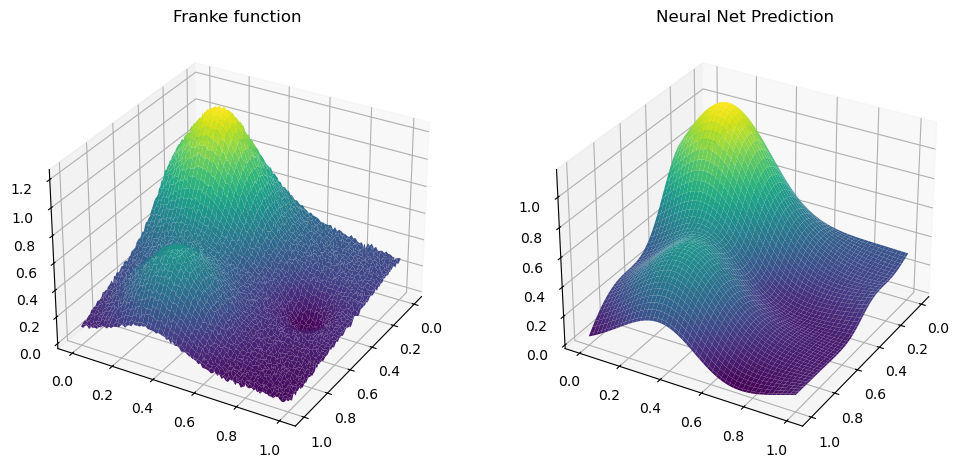

In [6]:
# Reshaping for plotting
x_plot = x.reshape((n,n))
y_plot = y.reshape((n,n))
z_plot = z_total.reshape((n,n))
z_orig_plot = z.reshape((n,n))

fig = plt.figure(figsize=(12, 6))

# Plotting the datapoints
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x_plot, y_plot, z_orig_plot, cmap='viridis', edgecolor='none')
ax.set_title('Franke function')
ax.view_init(azim=30)

# Plot the polynomial regression prediction 
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x_plot, y_plot, z_plot, cmap='viridis', edgecolor='none')
ax.set_title('Neural Net Prediction')
ax.view_init(azim=30)

plt.show()